In [1]:
image_size = 512
backbone='efficientdetv2_ds'
checkpoint='axial_detection_effdet_134352-epoch-52'

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

import pydicom
import pylibjpeg

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
from effdet import create_model

timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random
import numpy as np

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF
# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"

IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')

In [4]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test_df

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


## read dcm file


In [5]:
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit.
    """
    return dcm_ds.pixel_array * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept


def read_dcm(patient_dir, num_instance):
    dcm_path = os.path.join(patient_dir, f"{int(num_instance)}.dcm")
    ds = pydicom.dcmread(dcm_path)
    img2d = rescale_img_to_hu(ds)
    return normalize_hu(img2d)

def read_patient_dcm(patient_dir):
    """
    여기서 이미지를 정상적인 순서로 돌려 놓는다
    :param patient_dir:
    :return:
    """
    num_slices = len(glob.glob(patient_dir + "/*.dcm"))
    print(f"total slices {num_slices}")
    imgs = np.zeros((num_slices, 512, 512))
    image_positions = np.zeros((num_slices, 3))
    image_orientations = np.zeros((num_slices, 6))
    pixel_spacings = np.zeros((num_slices, 2))
    slice_thicknesses = np.zeros((num_slices, 1))

    ignore_count = 1
    for i in range(num_slices):
        dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        while os.path.exists(dcm_path) == False:
            ignore_count += 1
            dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        ds = pydicom.dcmread(dcm_path)

        image_positions[i, :] = ds.ImagePositionPatient
        image_orientations[i, :] = ds.ImageOrientationPatient
        pixel_spacings[i, :] = ds.PixelSpacing
        slice_thicknesses[i, :] = ds.SliceThickness

        img2d = rescale_img_to_hu(ds)

        imgs[i] = img2d

    is_flip = False
    # check z is in good direction
    if image_positions[0, 2] < image_positions[1, 2]:
        is_flip = True
        # flip image in z direction
        imgs = np.flip(imgs, axis=0)
        image_positions = np.flip(image_positions, axis=0)
        pixel_spacings = np.flip(pixel_spacings, axis=0)
        slice_thicknesses = np.flip(slice_thicknesses, axis=0)

    aspect = calculate_aspect(image_positions, pixel_spacings)
        
    return imgs, aspect


def normalize_hu(data):
    # normalize to 0-1
    # return (data - data.min()) / data.max()
    data = np.clip(data, a_min=-2242, a_max=2242) / 4484 + 0.5
    return data

def calculate_aspect(image_positions, pixel_spacings):
    """
    calculate z aspect, z 를 몇배로 늘여야 하는가야
    :param image_positions:
    :param pixel_spacings:
    :return:
    """
    height = image_positions[0, 2] - image_positions[1, 2]
    pixel_spacing = pixel_spacings[0, 0]
    aspect = height / pixel_spacing
    return aspect

## get boundary

In [6]:
class BoundaryDataTransform(nn.Module):
    def __init__(self, image_size=256):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

    def forward(self, x):
        
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        return x


def get_sagittal_boundary_model():
    model = models.efficientnet_v2_m(pretrained=False)
    conv1_weight = model.features[0][0].weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.features[0][0].weight = nn.Parameter(conv1_weight, requires_grad=True)

    model.avgpool = nn.Sequential(
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )
    # model.classifier[1] = nn.Linear(1280, 4, bias=True)
    model.classifier[1] = nn.Sequential(
        nn.Linear(81920, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, 4, bias=True)
    )
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', 'xray_effnet-m_boundary_193121-epoch-300.pth'))
    model.load_state_dict(state["model"])
    model = model.to(device).eval()
    
    
    transform = BoundaryDataTransform(256)
    
    return model, transform

def get_coronal_boundary_model():
    model = models.efficientnet_v2_m(pretrained=False)
    conv1_weight = model.features[0][0].weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.features[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.features[0][0].weight = nn.Parameter(conv1_weight, requires_grad=True)

    model.avgpool = nn.Sequential(
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )
    # model.classifier[1] = nn.Linear(1280, 4, bias=True)
    model.classifier[1] = nn.Sequential(
        nn.Linear(81920, 1024, bias=True),
        nn.ReLU(),
        nn.Linear(1024, 4, bias=True)
    )

    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', 'coronal_effnet-m_boundary_185858-epoch-300.pth'))
    model.load_state_dict(state["model"])
    model = model.to(device).eval()
    transform = BoundaryDataTransform(256)
    
    return model, transform


sagittal_boundary_model, sb_transform = get_sagittal_boundary_model()
coronal_boundary_model, cb_transform = get_coronal_boundary_model()

In [7]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).sort_values('StudyInstanceUID')
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
1837,1.2.826.0.1.3680043.10001,0,0,0,0,0,0,0,0
823,1.2.826.0.1.3680043.10005,0,0,0,0,0,0,0,0
1021,1.2.826.0.1.3680043.10014,0,0,0,0,0,0,0,0
667,1.2.826.0.1.3680043.10016,1,0,1,0,0,0,0,0
322,1.2.826.0.1.3680043.10032,0,0,0,0,0,0,0,0


In [1016]:
# UID = '1.2.826.0.1.3680043.15623'
# label = np.array([1,1,0,0,0,0,0,0])
index = 400
UID = train_df.iloc[index]['StudyInstanceUID']
print(UID)
label = train_df.iloc[index][['patient_overall', 'C1','C2','C3','C4','C5','C6','C7']].values
print(label)
imgs, aspect = read_patient_dcm(os.path.join(IMAGES_DIR, UID))
print(imgs.shape)
print(aspect)

1.2.826.0.1.3680043.16348
[0 0 0 0 0 0 0 0]
total slices 478
(478, 512, 512)
1.2799981795581425


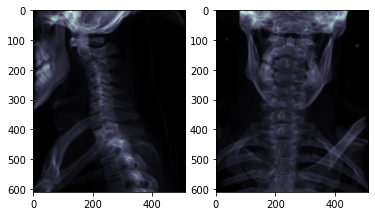

In [1017]:

def get_xray_images(imgs):
    xray_imgs = np.clip(imgs, a_min=0, a_max=2242)
    coronal_xray = xray_imgs.mean(axis=1)
    coronal_xray = coronal_xray / coronal_xray.max()
    coronal_img = Image.fromarray(np.uint8(coronal_xray * 255), 'L')
    coronal_img = coronal_img.resize((coronal_img.width, int(coronal_img.height * aspect)))

    sagittal_xray = xray_imgs.mean(axis=2)
    sagittal_xray = sagittal_xray / sagittal_xray.max()
    sagittal_img = Image.fromarray(np.uint8(sagittal_xray * 255), 'L')
    sagittal_img = sagittal_img.resize((sagittal_img.width, int(sagittal_img.height * aspect)))

    
    return sagittal_img, coronal_img

sagittal_img, coronal_img = get_xray_images(imgs)
_, axs = plt.subplots(1, 2)
axs[0].imshow(sagittal_img, cmap='bone')
axs[1].imshow(coronal_img, cmap='bone')

In [1018]:
def square_crop_position(crop_box, image_size=512):
    """
    crop box 를 정방형으로 만들어준다.
    :param left:
    :param top:
    :param right:
    :param bottom:
    :param image_size:
    :return:
    """
    left, top, right, bottom = crop_box
    w, h = right - left, bottom - top

    if h > w:
        left_pad = (h - w) // 2
        right_pad = h - w - left_pad
        left -= left_pad
        right += right_pad

        if left < 0:
            right -= left
            left = 0
        elif right > image_size:
            left -= right - image_size
            right = image_size
    else:
        top_pad = (w - h) // 2
        bottom_pad = w - h - top_pad
        top -= top_pad
        bottom += bottom_pad

        if top < 0:
            bottom -= top
            top = 0
        elif bottom > image_size:
            top -= bottom - image_size
            bottom = image_size
    return left, top, right, bottom

[ 99.689835  23.034586 395.1639   400.3163  ] [117.97781   28.026415 351.36163  382.8932  ]
[86, 99, 382, 395]
17 312


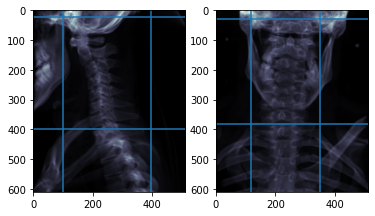

In [1019]:
sagittal_tensor = sb_transform(sagittal_img)
coronal_tensor = cb_transform(coronal_img)
with torch.no_grad():
    sagittal_boundary = sagittal_boundary_model(sagittal_tensor.unsqueeze(0).to(device))[0].sigmoid().cpu().numpy() * 512
    coronal_boundary = coronal_boundary_model(coronal_tensor.unsqueeze(0).to(device))[0].sigmoid().cpu().numpy() * 512
    print(sagittal_boundary, coronal_boundary)
    
    _, axs = plt.subplots(1, 2)
    
    # sagittal_boundary[0] = 100
    
    axs[0].imshow(sagittal_img, cmap='bone')
    axs[0].axvline(sagittal_boundary[0])
    axs[0].axvline(sagittal_boundary[2])
    axs[0].axhline(sagittal_boundary[1])
    axs[0].axhline(sagittal_boundary[3])
    
    axs[1].imshow(coronal_img, cmap='bone')
    axs[1].axvline(coronal_boundary[0])
    axs[1].axvline(coronal_boundary[2])
    axs[1].axhline(coronal_boundary[1])
    axs[1].axhline(coronal_boundary[3])
    
    axial_boundary = [coronal_boundary[0], sagittal_boundary[0], coronal_boundary[2], sagittal_boundary[2]]
    axial_boundary = square_crop_position(axial_boundary)
    axial_boundary = [int(num) for num in axial_boundary]
    
    start_axial_index = int(min(sagittal_boundary[1], coronal_boundary[1]) / aspect)
    start_axial_index = max(1, start_axial_index)
    
    end_axial_index = int(max(sagittal_boundary[3], coronal_boundary[3]) / aspect)
    end_axial_index = min(imgs.shape[0]-2, end_axial_index)
    
    # end_axial_index = imgs.shape[0]-2
    
    print(axial_boundary)
    print(start_axial_index, end_axial_index)
    

## detection model

In [1020]:



def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ]
    )


class DetectionTransform(nn.Module):
    def __init__(self, image_size=512):
        super().__init__()

        self.transform = A.Compose(
            [
                A.Resize(height=target_img_size, width=target_img_size, p=1),
                A.Normalize(0.5, 0.5),
                ToTensorV2(p=1),
            ]
        )

    def forward(self, x):
        
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        return x

def get_axial_detection_model():
    model = create_model(backbone , bench_task='predict' , num_classes= 1 , image_size=(512, 512), bench_labeler=True, pretrained=True)
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint',f'{checkpoint}.pth'))
    model.load_state_dict(state["model"])
    model = model.to(device).eval()
    
    return model

axial_detection_model = get_axial_detection_model()

In [1021]:
cliped_imgs = np.clip(imgs, a_min=-2242, a_max=2242) / 4484 + 0.5

def get_axial_tensor(cliped_imgs):
    axial_imgs = cliped_imgs[start_axial_index-1:end_axial_index+2, axial_boundary[1]:axial_boundary[3], axial_boundary[0]:axial_boundary[2]]
    # axial_imgs = axial_imgs / axial_imgs.max()
    axial_imgs = np.expand_dims(axial_imgs, axis=1)
    axial_tensors = torch.tensor(axial_imgs, dtype=torch.float)
    axial_tensors = TF.normalize(axial_tensors, 0.5, 0.5)
    axial_tensors = TF.resize(axial_tensors, (512, 512))
    print(axial_tensors.min(), axial_tensors.max())
    axial_tensors.shape
    
    return axial_tensors

axial_tensors = get_axial_tensor(cliped_imgs)

tensor(-0.4567) tensor(0.9975)


In [1022]:
# plt.imshow(axial_imgs[229-start_axial_index, 0, :, :], cmap='bone')

In [1023]:
# axial_tensors[200, :, 200:205, 200:205]

In [1024]:
# with torch.no_grad():
#     r = axial_tensors[[228-start_axial_index], :, :, :]
#     g = axial_tensors[[229-start_axial_index], :, :, :]
#     b = axial_tensors[[230-start_axial_index], :, :, :]
#     print(r.shape, g.shape, b.shape)
#     batch_tensor = torch.concat((r, g, b), axis=1)
#     plt.imshow(batch_tensor[0, 0, :, :], cmap='bone')
#     boxes = axial_detection_model(batch_tensor.to(device))[0, 0, :].cpu().numpy()
#     print(boxes)
# plt.imshow(batch_tensor[30, :, :, :].permute(1, 2, 0).cpu().numpy())

In [1025]:
batch_size = 32
bbox_list = []

with torch.no_grad():
    
    for i in range(math.ceil((axial_tensors.shape[0]-2) / batch_size)):
        
        r = axial_tensors[batch_size * i:min(batch_size * (i+1), axial_tensors.shape[0]-2), :, :, :]
        g = axial_tensors[batch_size * i+1:min(batch_size * (i+1)+1, axial_tensors.shape[0]-1), :, :, :]
        b = axial_tensors[batch_size * i+2:min(batch_size * (i+1)+2, axial_tensors.shape[0]), :, :, :]
        print(r.shape, g.shape, b.shape)
        batch_tensor = torch.concat((r, g, b), axis=1)
        # print(batch_tensor.shape)
        bbox = axial_detection_model(batch_tensor.to(device))[:, 0, :].cpu().numpy()

        bbox_list.append(bbox)

        

torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512]) torch.Size([32, 1, 512, 512])
torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512])


In [1026]:
bbox_list = np.concatenate(bbox_list)
bbox_list.shape

(296, 6)

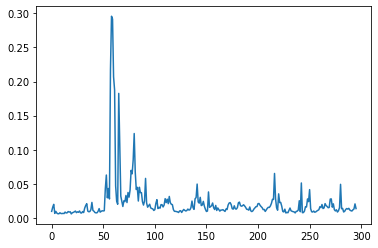

In [1027]:
plt.plot(bbox_list[:, 4])

[]
[]


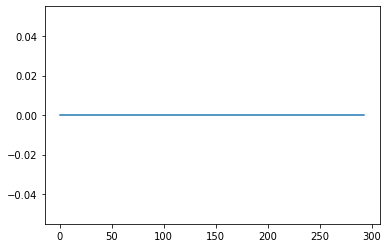

In [1028]:
def detected_bbox(bboxes_list, threshold=0.6):
    
    class_list = np.copy(bboxes_list[:, 4])
    class_list[class_list < threshold] = 0
    neg_list = 1 - class_list
    neg_score = neg_list[0:-2] * neg_list[1:-1] * neg_list[2:]
    pos_score = 1 - neg_score
    
    plt.plot(pos_score)
    
    detected_slices = pos_score.nonzero()[0]
    
    nonzero_slices = bboxes_list[detected_slices, 4].nonzero()[0]
    detected_slices = detected_slices[nonzero_slices]
    
    return detected_slices, bboxes_list[detected_slices, :]
    
detected_slices, detected_boxes = detected_bbox(bbox_list)
print(detected_slices)
print(detected_boxes)

In [1029]:
def cal_loss(prob, label):
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()

In [1030]:
if len(detected_boxes) == 0:
    prob = np.zeros(8) + 0.01
    prob[0] = max(bbox_list[:, 4].max(), 0.01)
    # print(prob)
    print(cal_loss(prob, label))
    

0.1804063509636929


In [1031]:
if len(detected_slices) > 0:
    detected_slice_index = 0
    plt.imshow(axial_tensors[detected_slices[detected_slice_index], 0, :, :], cmap='bone')
    plt.axvline(bbox_list[detected_slices[detected_slice_index],0])
    plt.axvline(bbox_list[detected_slices[detected_slice_index],2])
    plt.axhline(bbox_list[detected_slices[detected_slice_index],1])
    plt.axhline(bbox_list[detected_slices[detected_slice_index],3])

In [1032]:
axial_imgs.shape

(282, 1, 298, 298)

In [1033]:
axial_boundary

[86, 99, 382, 395]

In [1034]:
real_boxes = np.copy(detected_boxes)
real_boxes[:, :4] =  real_boxes[:, :4] / (512 / axial_imgs.shape[-1])
real_boxes[:, [0, 2]] += axial_boundary[0]
real_boxes[:, [1, 3]] += axial_boundary[1]
real_boxes

array([], shape=(0, 6), dtype=float32)

In [1035]:
frac_prob = real_boxes[:, 4]
frac_prob

array([], dtype=float32)

In [1036]:
real_slice_numbers = detected_slices + start_axial_index
real_slice_numbers

array([], dtype=int64)

In [1037]:
# plt.imshow(imgs[102])
# plt.axvline(real_boxes[7, 0])
# plt.axvline(real_boxes[7, 2])
# plt.axhline(real_boxes[7, 1])
# plt.axhline(real_boxes[7, 3])

## segmentation

In [1038]:
# inference sagittal indices
sagittal_indices = (real_boxes[:, 2] + real_boxes[:, 0]) // 2
sagittal_indices = [int(x) for x in sagittal_indices]
sagittal_indices

[]

In [1039]:
def croped_seg_position(left, top, aspect, boundary):
    print(left)
    
    top = top.astype(np.float)
    top *= aspect
    print(top)
    left -= boundary[0]
    top -= boundary[1]
    bh, bw = boundary[3] - boundary[1], boundary[2] - boundary[0]
    if bh > bw:
        pad = (bh - bw) // 2
        left += pad
        scale = bh / 256
    else:
        pad = (bw - bh) // 2
        top += pad
        scale = bw / 256
    top, left = top // scale, left // scale
    return np.stack((left, top), axis=1)

sagittal_pos = croped_seg_position((real_boxes[:, 1] + real_boxes[:, 3]) / 2, real_slice_numbers, aspect, sagittal_boundary)
coronal_pos = croped_seg_position((real_boxes[:, 0] + real_boxes[:, 2]) / 2, real_slice_numbers, aspect, coronal_boundary)
print(sagittal_pos)
print(coronal_pos)

[]
[]
[]
[]
[]
[]


In [1040]:
def transform_seg(tensor, boundary, aspect):
    
    boundary_width = boundary[2] - boundary[0]
    boundary_height = boundary[3] - boundary[1] + 100
    
    tensor = torch.tensor(tensor, dtype=torch.float)
    tensor = TF.resize(tensor, (int(tensor.shape[1] * aspect), int(tensor.shape[2])))
   
    tensor = TF.crop(tensor, top=int(sagittal_boundary[1]), left=int(boundary[0]), width=int(boundary_width), height=int(boundary_height))
  
    tensor = TF.center_crop(tensor, max(tensor.shape[-1], tensor.shape[-2]))
    tensor = TF.resize(tensor, 256)
    tensor = TF.normalize(tensor, 0.5, 0.5)
    
    return tensor.unsqueeze(1)

In [1041]:
sagittal_img = cliped_imgs[:, :, sagittal_indices].transpose(2, 0, 1)

IndexError: index 0 is out of bounds for axis 0 with size 0

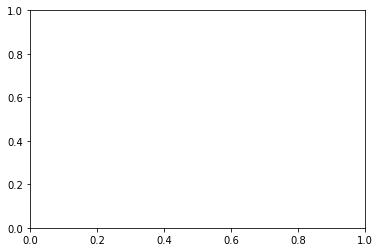

In [1042]:
_, ax = plt.subplots(1)
ax.imshow(sagittal_img[0])

ax.axvline(sagittal_pos[0,0])
ax.axhline(sagittal_pos[0,1])
ax.set_aspect(aspect)

In [ ]:
sagittal_tensor = transform_seg(sagittal_img, sagittal_boundary, aspect)
print(sagittal_tensor.min(), sagittal_tensor.max())
print(sagittal_tensor.shape)
plt.imshow(sagittal_tensor[0, 0])
# plt.axvline(56)
# plt.axhline(112)

In [ ]:
coronal_indices = (real_boxes[:, 3] - real_boxes[:, 1]) // 2
coronal_indices = [int(x) for x in coronal_indices]
coronal_indices

In [ ]:
coronal_img = cliped_imgs[:, coronal_indices, :].transpose(1, 0, 2)
coronal_tensor = transform_seg(coronal_img, coronal_boundary, aspect)
print(coronal_tensor.min(), coronal_tensor.max())
print(coronal_tensor.shape)
plt.imshow(coronal_tensor[0, 0])
# plt.axvline(56)
# plt.axhline(112)

In [ ]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, 2 * self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(2 * self.out_channels, self.n_features, kernel_size=1, padding='same'),
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=1, padding='same'),
            )
            parallel_modules.append(module)


        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i] // 2, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i] // 2, self.channels[i-1] if i > 0 else self.out_channels, kernel_size=1),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules



    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i+1)]
            parallel_output = parallel_outputs[-(i+1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out

    
def get_sagittal_segmentation_model():
    backbone = models.resnet50(pretrained=False)
    conv1_weight = backbone.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    backbone.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    channels = [64, 512, 1024, 2048]
    
    model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)
    
    sagittal_checkpoint = 'sagittal_segmentation_detection_095730-epoch-20.pth'
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', sagittal_checkpoint))
    model.load_state_dict(state["model"])
    model = model.eval()
    
    return model

def get_coronal_segmentation_model():
    backbone = models.resnet50(pretrained=False)
    conv1_weight = backbone.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    backbone.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    channels = [64, 512, 1024, 2048]
    
    model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)
    
    coronal_checkpoint = 'coronal_segmentation_detection_142529-epoch-20.pth'
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', coronal_checkpoint))
    model.load_state_dict(state["model"])
    model = model.eval()
    
    return model

sagittal_seg_model = get_sagittal_segmentation_model()
coronal_seg_model = get_coronal_segmentation_model()

In [ ]:
def predict_segmentation(model, x):
    x = x.to(device)
    classification_prob, mse_score = model(x).sigmoid().chunk(2, dim=1)
    mse_score = torch.round(mse_score * 8.) / 8.
    pred = classification_prob.gt(0.5).float() * mse_score
    return pred

In [ ]:
with torch.no_grad():
    sagittal_seg = predict_segmentation(sagittal_seg_model, sagittal_tensor)
    print(sagittal_seg.shape)
    # print(sagittal_seg[7, 0, 56, 112])
    sagittal_classes = sagittal_seg[np.arange(sagittal_pos.shape[0]), 0, sagittal_pos[:, 0], sagittal_pos[:, 1]] // 0.125
    sagittal_classes = sagittal_classes.cpu().numpy()
    print(sagittal_classes)
    plt.imshow(sagittal_seg[0, 0].cpu().numpy(), cmap='bone')

In [ ]:
with torch.no_grad():
    coronal_seg = predict_segmentation(coronal_seg_model, coronal_tensor)
    print(coronal_seg.shape)
    # print(coronal_seg[7, 0, 56, 112])
    coronal_classes = coronal_seg[np.arange(coronal_pos.shape[0]), 0, coronal_pos[:, 0], coronal_pos[:, 1]] // 0.125
    coronal_classes = coronal_classes.cpu().numpy()
    print(coronal_classes)
    plt.imshow(coronal_seg[0, 0].cpu().numpy(), cmap='bone')

In [ ]:
frac_classes = np.max((sagittal_classes, coronal_classes), axis=0)

frac_result = np.zeros(8) + 0.01
for i in range(frac_classes.shape[0]):
    if frac_classes[i] == 0:
        continue
    class_index = int(frac_classes[i])
    frac_result[class_index] = max(frac_result[class_index], frac_prob[i])

frac_result[0] = max(frac_prob)
frac_result

In [ ]:

    
cal_loss(frac_result, label)